# Adversarial AEs

* VAE 는 KL-divergence 로 q(z|x) 에 p(z)~N(0,1) 로 prior 를 걸어줌
* 이걸 adversarial loss (discriminator 사용) 를 통해 해주겠다는 것
    * q(z|x) 를 학습할 때 D 를 잘 속이도록!
    * D 는 p(z) 와 q(z|x) 를 구분하지 못하도록!

### Question:

* VAE 와 비교해서 장점이 뭐지?
    * VAE 는 monte-carlo 혹은 analytic 하게 하던걸 adversarial loss 로 바꾼건데...

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
mnist = input_data.read_data_sets('../MNIST_data/', one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [4]:
def show_plot(samples):
    fig = plot(samples)
    plt.show()
    plt.close(fig)

In [5]:
x_dim = 784
h_dim = 128
z_dim = 10

In [6]:
# q(z|x)
# input: x
# output: mu, sigma for z => z
# AAE 에서는 VAE 와 다르게 prior 가 임의의 확률분포여도 된다. 즉, 특정한 확률분포로 가정하지 않는다.
# 따라서 mu/sigma 를 학습하는 것이 아니라 z 자체를 학습한다.
def encoder(x):
    net = x
    with tf.variable_scope("encoder"):
        net = tf.layers.dense(net, h_dim, activation=tf.nn.relu, 
                              weights_initializer=tf.contrib.layers.xavier_initializer())
        net = tf.layers.dense(net, h_dim, activation=tf.nn.relu, 
                              weights_initializer=tf.contrib.layers.xavier_initializer())
        z = tf.layers.dense(net, z_dim)
    
    return z

In [7]:
# p(x|z)
# input: z
# output: logits of x
def decoder(z, reuse=False):
    net = z
    with tf.variable_scope("decoder", reuse=reuse):
        net = tf.layers.dense(net, h_dim, activation=tf.nn.relu, 
                              weights_initializer=tf.contrib.layers.xavier_initializer(), reuse=reuse)
        net = tf.layers.dense(net, h_dim, activation=tf.nn.relu, 
                              weights_initializer=tf.contrib.layers.xavier_initializer(), reuse=reuse)
        logits = tf.layers.dense(net, x_dim, reuse=reuse)
        x = tf.nn.sigmoid(logits)
    
    return x, logits

In [8]:
def D(z, reuse=False):
    net = z
    with tf.variable_scope("discriminator", reuse=reuse):
        net = tf.layers.dense(net, h_dim, activation=tf.nn.relu, 
                              weights_initializer=tf.contrib.layers.xavier_initializer(), reuse=reuse)
#         net = tf.layers.dense(net, h_dim, activation=tf.nn.relu, 
#                               weights_initializer=tf.contrib.layers.xavier_initializer(), reuse=reuse)
        logits = tf.layers.dense(net, 1, reuse=reuse)
    
    return logits

In [9]:
# make tf graph
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, 784])
Z = tf.placeholder(tf.float32, shape=[None, z_dim]) # 임의의 z 분포를 학습

z_ = encoder(X)
x_generated, y_logits = decoder(z_)

# 여기서 D 가 필요하다. Z 와 z 를 구분할 수 없도록 encoder 가 학습되어야 하고, D 는 Z 와 z 를 구분하도록 학습되어야 함
D_logits_real = D(Z)
D_logits_fake = D(z_, reuse=True)

# reconstruction loss for Bernoulli MLP as decoder (appendix C.1 in paper)
# sigmoid_cross_entropy: z * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x))
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_logits, labels=X))
# regularization loss (kl-divergence, appendix B in paper)
# reg_loss = -0.5 * tf.reduce_sum(1 + z_log_var - z_mu**2 - tf.exp(z_log_var))
# 이 reg loss 를 adversarial loss 로 대체한다
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_real, labels=tf.ones_like(D_logits_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_fake, labels=tf.zeros_like(D_logits_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_fake, labels=tf.ones_like(D_logits_fake)))

# loss = recon_loss + reg_loss # minimize
# ELBO = -loss # recon_loss 랑 reg_loss 에 loss 라는 이름이 붙어서 위처럼 해주는게 맞는것같음.

# get variables
var_encoder = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='encoder')
var_decoder = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='decoder')
var_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')

# train_op = tf.train.AdamOptimizer().minimize(loss)
train_op_AE = tf.train.AdamOptimizer().minimize(recon_loss, var_list = var_encoder + var_decoder)
train_op_D = tf.train.AdamOptimizer().minimize(D_loss, var_list = var_D)
train_op_G = tf.train.AdamOptimizer().minimize(G_loss, var_list = var_encoder) 
# 요로코롬 하는게 맞음? 논문을 안봐서 모르겠.

summary_op = tf.summary.merge([
#         tf.summary.scalar("loss", loss),
        tf.summary.scalar('reconstruction_loss', recon_loss),
#         tf.summary.scalar('regularization_loss', reg_loss)
        tf.summary.scalar('D_loss', D_loss),
        tf.summary.scalar('G_loss', G_loss)
    ])

In [10]:
print map(len, [var_encoder, var_decoder, var_D])

[6, 6, 4]


In [11]:
# sampling graph
# VAE 와는 달리 AAE 에서는 z 를 placeholder 로 받으므로 샘플링을 위해 새로 placeholder 를 만들어줄 필요가 없음
# z_sampling = tf.placeholder(tf.float32, shape=[None, z_dim])
x_sampling, _ = decoder(Z, reuse=True)

[1/200] recon: 26052.05, D: 1.4755, G: 0.7492


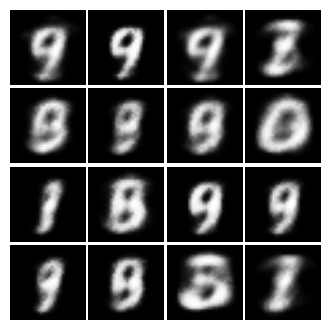

[10/200] recon: 13690.85, D: 1.3938, G: 0.6922


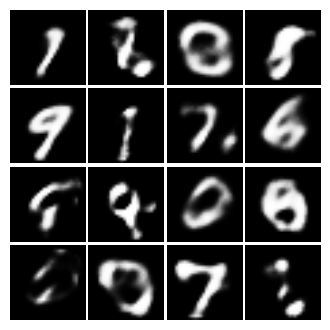

[20/200] recon: 12371.07, D: 1.3928, G: 0.6932


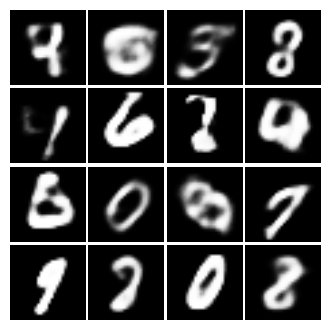

[30/200] recon: 11947.25, D: 1.3914, G: 0.6928


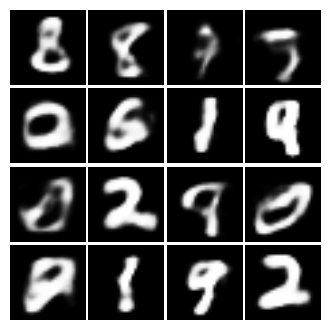

[40/200] recon: 11964.16, D: 1.3954, G: 0.6921


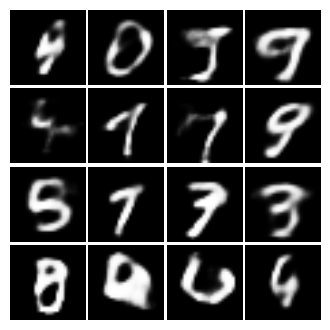

[50/200] recon: 11448.65, D: 1.3882, G: 0.6939


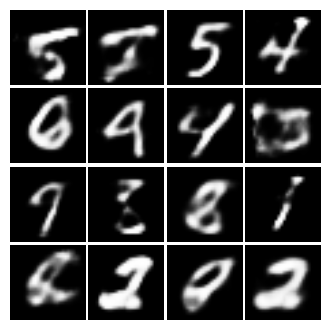

[60/200] recon: 11314.72, D: 1.3887, G: 0.6928


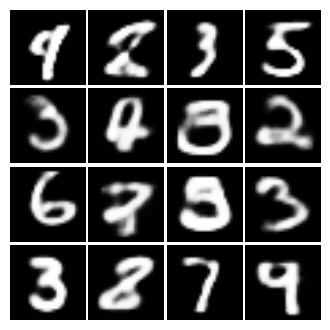

[70/200] recon: 11135.42, D: 1.3891, G: 0.6926


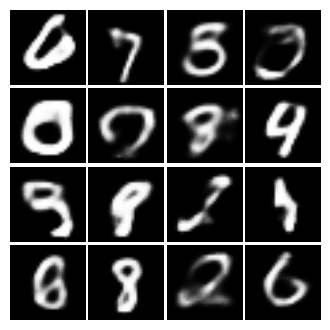

[80/200] recon: 11324.29, D: 1.3897, G: 0.6920


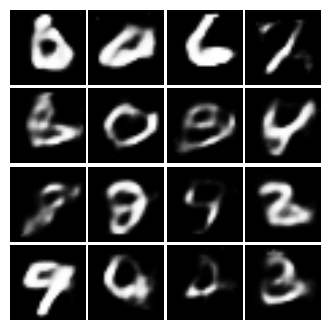

[90/200] recon: 10995.28, D: 1.3878, G: 0.6931


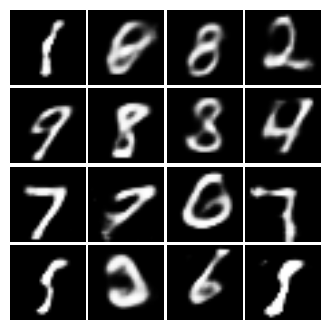

[100/200] recon: 10970.68, D: 1.3881, G: 0.6928


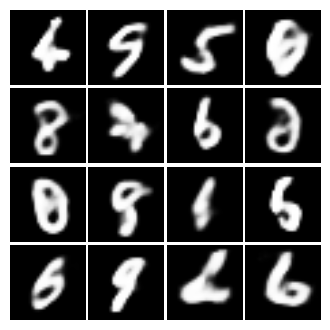

[110/200] recon: 11079.18, D: 1.3884, G: 0.6929


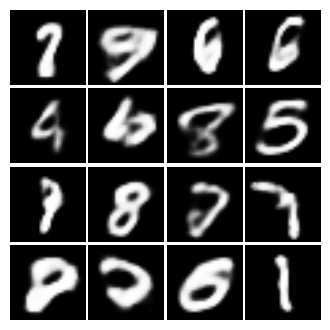

[120/200] recon: 10583.90, D: 1.3865, G: 0.6931


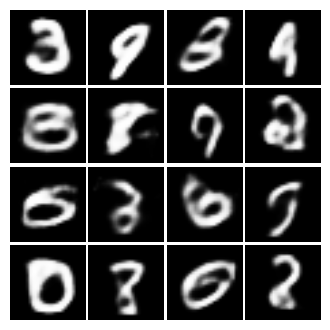

[130/200] recon: 10444.52, D: 1.3864, G: 0.6931


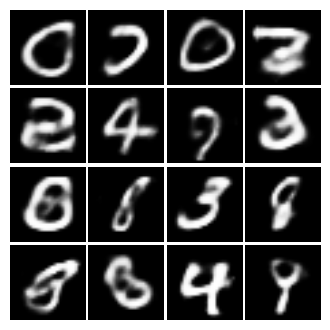

[140/200] recon: 10333.61, D: 1.3863, G: 0.6931


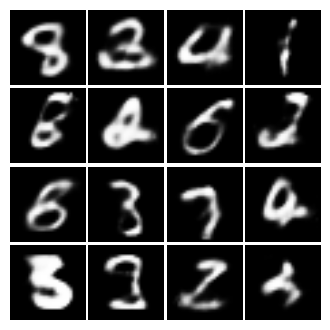

[150/200] recon: 10262.77, D: 1.3863, G: 0.6931


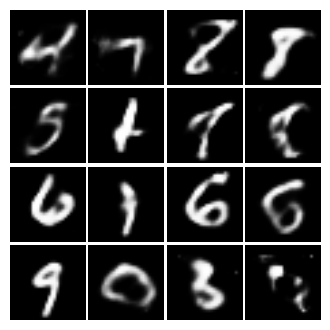

[160/200] recon: 10215.66, D: 1.3863, G: 0.6931


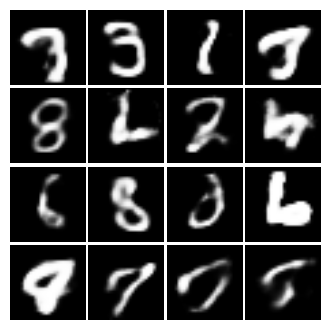

[170/200] recon: 10178.98, D: 1.3863, G: 0.6931


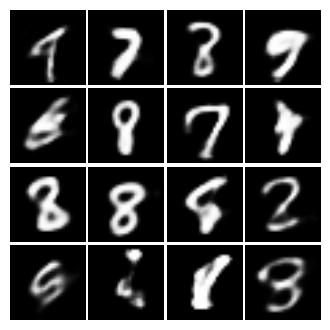

[180/200] recon: 10155.83, D: 1.3863, G: 0.6931


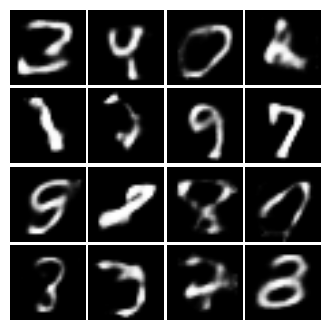

[190/200] recon: 10132.32, D: 1.3863, G: 0.6931


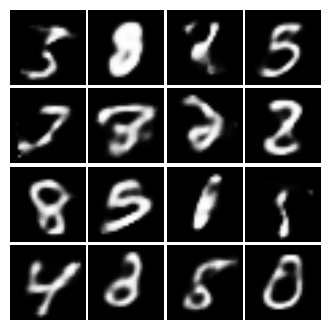

[200/200] recon: 10176.70, D: 1.3863, G: 0.6931


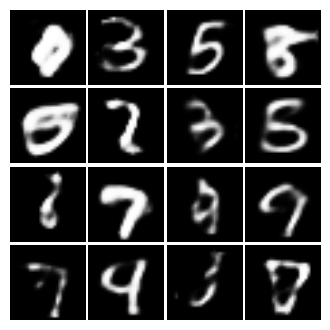

In [12]:
epoch_n = 200
batch_size = 128
N = mnist.train.num_examples

sess = tf.Session()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter("./tmp/", sess.graph)
global_step = 0

for epoch in range(epoch_n):
    recon_loss_avg = 0
    D_loss_avg = 0
    G_loss_avg = 0
    for _ in range(N // batch_size):
        global_step += 1
        X_batch, _ = mnist.train.next_batch(batch_size)
        Z_batch = np.random.randn(batch_size, z_dim)
#         _, recon_loss_cur, D_loss_cur, G_loss_cur, summary_cur = \
#         sess.run([train_op, recon_loss, D_loss, G_loss, summary_op], {X: X_batch})
        _, recon_loss_cur = sess.run([train_op_AE, recon_loss], {X: X_batch})
        _, D_loss_cur = sess.run([train_op_D, D_loss], {X: X_batch, Z: Z_batch})
        _, G_loss_cur = sess.run([train_op_G, G_loss], {X: X_batch})
        recon_loss_avg += recon_loss_cur
        D_loss_avg += D_loss_cur
        G_loss_avg += G_loss_cur
#         writer.add_summary(summary_cur, global_step)
    
    if epoch == 0 or (epoch+1) % 10 == 0:
        recon_loss_avg /= (N // batch_size)
        D_loss_avg /= (N // batch_size)
        G_loss_avg /= (N // batch_size)
        print("[{}/{}] recon: {:.2f}, D: {:.4f}, G: {:.4f}".format(epoch+1, epoch_n, recon_loss_avg, D_loss_avg, G_loss_avg))
        samples = sess.run(x_sampling, {Z: np.random.randn(16, z_dim)}) 
        show_plot(samples)

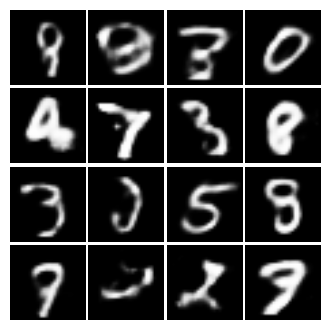

In [13]:
samples = sess.run(x_sampling, {z_sampling: np.random.randn(16, z_dim)}) 
show_plot(samples)

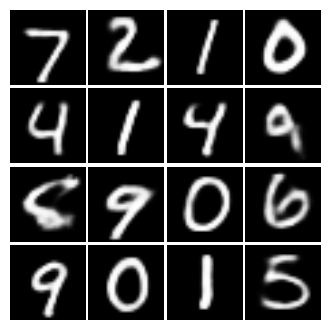

In [14]:
samples = sess.run(x_generated, {X: mnist.test.images[:16]})
show_plot(samples)

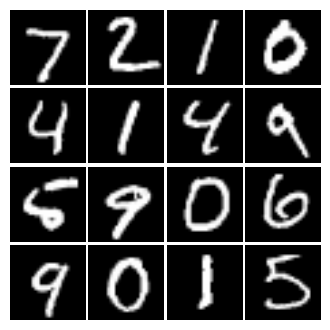

In [15]:
show_plot(mnist.test.images[:16])

# Latent space walking

In [16]:
def interpolate(st, ed, n=16):
    diff = ed - st
    step = diff / n
    return np.array([st + step*i for i in range(n)])

In [17]:
encoded_z = sess.run(z_, {X: mnist.test.images[:16]})

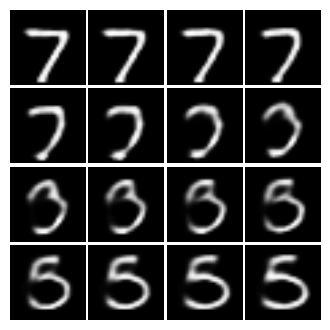

In [18]:
walking_z = interpolate(encoded_z[0], encoded_z[15])
samples = sess.run(x_sampling, {z_sampling: walking_z})
show_plot(samples)

#  Conclusion

* adversarial loss 를 사용하면 GAN 과 마찬가지로 mode collapse 가 일어난다.
* 특히 여기서는 G 가 학습하는것이 N(0,1) 로 매우 쉬운 함수이기 때문에 굉장히 빠르고 심하게 일어남.

But

* 재미있는 건... z dim 을 낮게 사용하면 mode collapse 가 발생하지 않음.
* z dim 에만 한정된 조건은 아닌 것 같고... 흠... 히든레이어 개수도 중요한거같기도 하고...